# SIR model simulation of the Kermack & McKendrick EDO system.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

In [17]:
# Constants
states = {
    'S': 0, # Susceptible
    'I': 1, # Infected
    'R': 2, # Recovered
}

In [18]:
# Parameters
M, N = 32, 32 # Grid size
T = 100 # Number of time steps
I_0 = 5 # Initial number of infected individuals
rad = 1 # Interaction radius
beta = 0.3 # Infection rate (0 <= beta <= 1)
gamma = 0.05 # Recovery rate (0 <= gamma <= 1)

## Model Functions

In [19]:
def initGrid(M, N, I_0, initial_positions=None):
    """
    Initialize the grid with susceptible and infected individuals.

    Args:
    M, N (int): Grid dimensions
    I_0 (int): Number of initial infected individuals
    initial_positions (list): Optional list of (x, y) tuples for initial infected positions

    Returns:
    numpy.ndarray: Initialized grid
    """
    grid = np.zeros((M, N))
    if initial_positions is None:
        for i in range(I_0):
            x, y = np.random.randint(0, M), np.random.randint(0, N)
            grid[x, y] = 1
    else:
        for x, y in initial_positions:
            grid[x, y] = 1
    return grid

In [20]:
def getNeighbors(x, y, M, N, rad):
    """
    Get the neighbors of a cell within a given radius.

    Args:
    x, y (int): Cell coordinates
    M, N (int): Grid dimensions
    rad (int): Radius for neighborhood

    Returns:
    list: List of neighboring cell coordinates
    """
    neighbors = []
    for i in range(-rad, rad + 1):
        for j in range(-rad, rad + 1):
            if i == 0 and j == 0:
                continue
            if 0 <= x + i < M and 0 <= y + j < N:
                neighbors.append((x + i, y + j))
    return neighbors

In [21]:
def nextIteration(grid, rad, beta, gamma):
    """
    Compute the next iteration of the SIR model.

    Args:
    grid (numpy.ndarray): Current state of the grid
    rad (int): Radius for neighborhood
    beta (float): Infection rate
    gamma (float): Recovery rate

    Returns:
    tuple: Updated grid and counts of S, I, R individuals
    """
    I, S, R = 0, 0, 0
    M, N = grid.shape
    newGrid = np.zeros((M, N))
    for i in range(M):
        for j in range(N):
            if grid[i, j] == states['S']:
                S += 1
                infected_neighbors = sum(1 for x, y in getNeighbors(i, j, M, N, rad) if grid[x, y] == states['I'])
                if infected_neighbors > 0 and np.random.random() < 1 - (1 - beta) ** infected_neighbors:
                    newGrid[i, j] = states['I']
                else:
                    newGrid[i, j] = states['S']
            elif grid[i, j] == states['I']:
                I += 1
                if np.random.random() < gamma:
                    newGrid[i, j] = states['R']
                else:
                    newGrid[i, j] = states['I']
            else:
                R += 1
                newGrid[i, j] = states['R']
    return newGrid, S, I, R

## Utility functions

In [27]:
def createGif(gridHist, filename='sir_simulation.gif'):
    """
    Create and save a gif of the grid evolution, showing the step number on each frame.

    Args:
    gridHist (list): List of grid states over time
    filename (str): Name of the output gif file
    """
    fig, ax = plt.subplots()
    ims = []
    for t, grid in enumerate(gridHist):
        im = ax.imshow(grid, cmap='viridis', animated=True)
        text = ax.text(0.02, 0.95, f'Step: {t}', transform=ax.transAxes, color='white',
                       fontweight='bold', bbox=dict(facecolor='black', alpha=0.5))
        ims.append([im, text])

    ani = animation.ArtistAnimation(fig, ims, interval=200, blit=False, repeat_delay=1000)
    ani.save(filename, writer='pillow')
    plt.close()

In [23]:
def evolutionPlot(SHist, IHist, RHist):
    """
    Plot the evolution of S, I, R populations over time.

    Args:
    SHist, IHist, RHist (list): Lists of S, I, R counts over time
    """
    plt.figure(figsize=(10, 6))
    plt.plot(SHist, label='Susceptible')
    plt.plot(IHist, label='Infected')
    plt.plot(RHist, label='Recovered')
    plt.xlabel('Time')
    plt.ylabel('Number of individuals')
    plt.legend()
    plt.title('SIR Model Simulation')
    plt.show()

## Simulation Functions

In [24]:
def simulation(M, N, T, I_0, rad, beta, gamma, initial_positions=None):
    """
    Run a complete SIR model simulation.

    Args:
    M, N (int): Grid dimensions
    T (int): Number of time steps
    I_0 (int): Number of initial infected individuals
    rad (int): Radius for neighborhood
    beta (float): Infection rate
    gamma (float): Recovery rate
    initial_positions (list): Optional list of (x, y) tuples for initial infected positions

    Returns:
    tuple: Lists of grid states and S, I, R counts over time
    """
    gridHist = []
    IHist = []
    SHist = []
    RHist = []
    grid = initGrid(M, N, I_0, initial_positions)
    for _ in range(T):
        grid, S, I, R = nextIteration(grid, rad, beta, gamma)
        gridHist.append(grid)
        SHist.append(S)
        IHist.append(I)
        RHist.append(R)
    return gridHist, SHist, IHist, RHist

In [25]:
def runMultipleSimulations(M, N, T, I_0, rad, beta, gamma, N_exp, initial_positions=None):
    """
    Run multiple simulations and compute average dynamics.

    Args:
    M, N (int): Grid dimensions
    T (int): Number of time steps
    I_0 (int): Number of initial infected individuals
    rad (int): Radius for neighborhood
    beta (float): Infection rate
    gamma (float): Recovery rate
    N_exp (int): Number of experiments to run
    initial_positions (list): Optional list of (x, y) tuples for initial infected positions

    Returns:
    tuple: Average S, I, R counts and grid states over time
    """
    all_S = np.zeros((N_exp, T))
    all_I = np.zeros((N_exp, T))
    all_R = np.zeros((N_exp, T))
    all_grids = np.zeros((N_exp, T, M, N))

    for i in range(N_exp):
        gridHist, SHist, IHist, RHist = simulation(M, N, T, I_0, rad, beta, gamma, initial_positions)
        all_S[i] = SHist
        all_I[i] = IHist
        all_R[i] = RHist
        all_grids[i] = gridHist

    avg_S = np.mean(all_S, axis=0)
    avg_I = np.mean(all_I, axis=0)
    avg_R = np.mean(all_R, axis=0)
    avg_grids = np.mean(all_grids, axis=0)

    return avg_S, avg_I, avg_R, avg_grids

## Testing the model

In [28]:
M, N = 100, 100  # Grid dimensions
T = 100  # Number of time steps
I_0 = 5  # Initial number of infected individuals
rad = 1  # Interaction radius
beta = 0.3  # Infection rate
gamma = 0.1  # Recovery rate

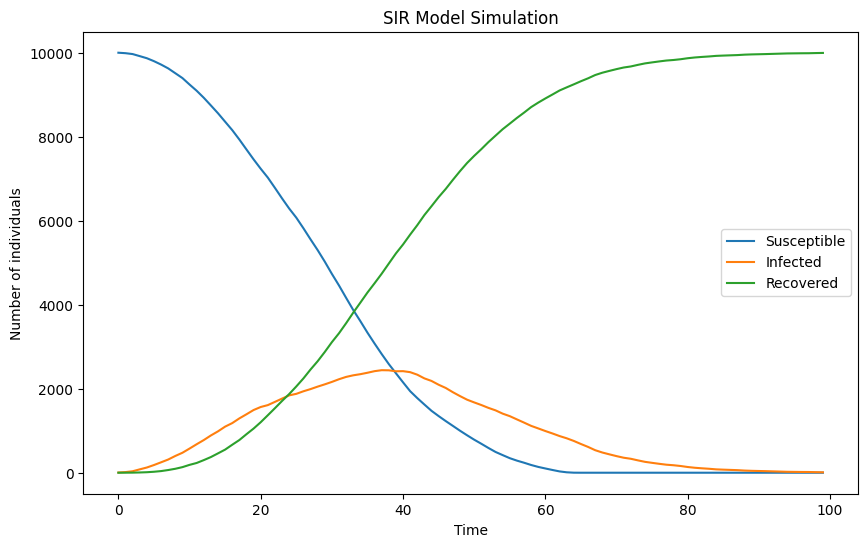

In [31]:
# Single simulation
gridHist, SHist, IHist, RHist = simulation(M, N, T, I_0, rad, beta, gamma)
createGif(gridHist)
evolutionPlot(SHist, IHist, RHist)

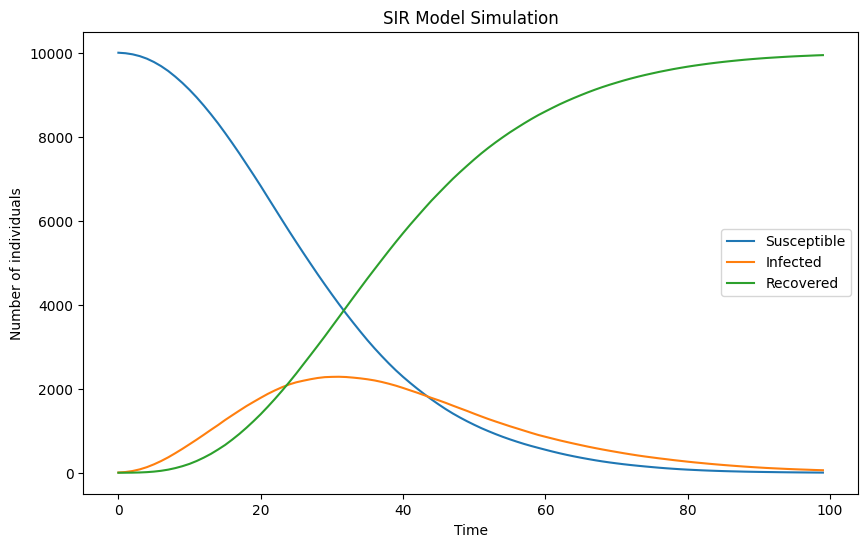

In [32]:
# Multiple simulations
N_exp = 50
avg_S, avg_I, avg_R, avg_grids = runMultipleSimulations(M, N, T, I_0, rad, beta, gamma, N_exp)
evolutionPlot(avg_S, avg_I, avg_R)
createGif(avg_grids, 'average_sir_simulation.gif')

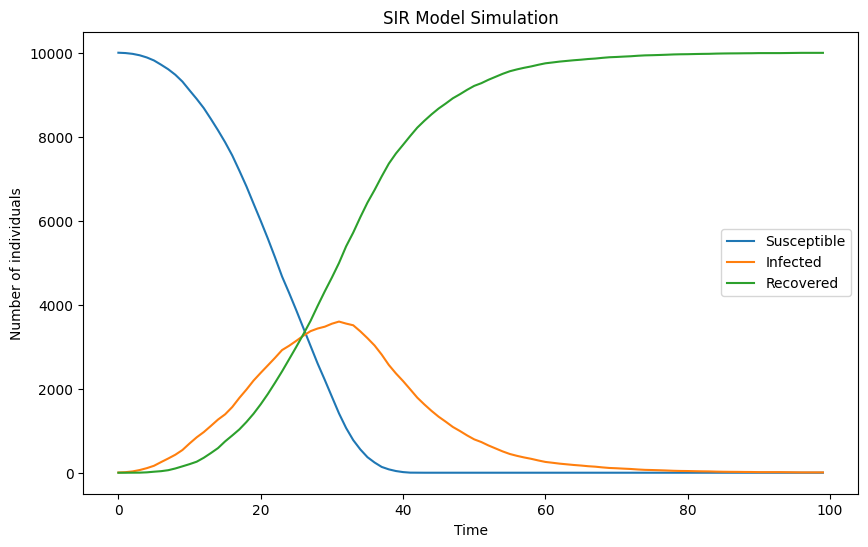

In [33]:
# Simulation with predefined initial positions
initial_positions = [(50, 50), (25, 25), (75, 75), (25, 75), (75, 25)]
gridHist, SHist, IHist, RHist = simulation(M, N, T, I_0, rad, beta, gamma, initial_positions)
createGif(gridHist, 'predefined_sir_simulation.gif')
evolutionPlot(SHist, IHist, RHist)